In [1]:
import numpy as np
import pandas as pd
import pickle
from functools import partial
import matplotlib.pyplot as plt

from SubpopulationsLib.DataProcessing import create_SIR_data
from SubpopulationsLib.InfectiousModels import SIR
from SubpopulationsLib.Metrics import MAPE
from SubpopulationsLib.Subpopulations import create_gaussian_dictionary, \
    find_theta_dictionary, find_theta_sa
from SubpopulationsLib.Subpopulations import mixture_exponentials, mixture_SIR

# Set the parameters of this experiment

In [2]:
# Determine the dates to use
start_date = '7/30/20'
end_date = '7/30/21'

# Set the path to the datasets
file_path = './Data/'
lookup_table_path = './Data/UID_ISO_FIPS_LookUp_Table.csv'

# Get the name of all available countries in the dataset
dataframe = pd.read_csv(lookup_table_path)

country_names = np.unique(dataframe['Country_Region'].values)
num_countries = len(country_names)

# Set the parameters for the Dictionary approaches

In [3]:
# Create a dictionaty with Gaussians
T = 52
possible_mu = np.arange(0,52,2)
possible_sigma = np.arange(1,30,2)
possible_skewness = np.array([0])

D_Gaussian = create_gaussian_dictionary(
    T, possible_mu, possible_sigma, possible_skewness
)

# Load the dictionary with SIR
D_SIR = pickle.load(open('./D_SIR.pkl', 'rb'))

# Set the parameters for the mixture of signals approach

In [4]:
num_mixtures = 2

# For the Gaussian model
bounds_mu = (0,50)
bounds_sigma = (1,6)
bounds_coef = (0,300000)

bound_list_Gaussian = [bounds_mu, bounds_sigma, bounds_coef]

bounds_Gaussian = list()

for element in bound_list_Gaussian:
    for i in range(num_mixtures):
        bounds_Gaussian.append(element)
        
# For the SIR model
bound_S = (0,1E8)
bound_beta = (0,1)
bound_gamma = (0,1)
bound_coef = (0,1000)
bound_k = (0,50)
bound_list_SIR = [bound_S, bound_beta, bound_gamma, bound_coef, bound_k]

bounds_SIR = list()

for element in bound_list_SIR:
    for i in range(num_mixtures):
        bounds_SIR.append(element)

# Run the experiment for all the countries

In [5]:
# ---------------
# Create a dictionary to store the results
# ---------------
reconstuction_results = dict()
country = 'Canada'

S, I, R = create_SIR_data(country, file_path, lookup_table_path, start_date, end_date)

indexes_weekly = np.arange(0,S.shape[0],7)

S = S[indexes_weekly]
I = I[indexes_weekly]
R = R[indexes_weekly]

# Normalize the data of the infected people
data = I[1:]
bias = np.min(data)
norm_I = data - bias

# -----------------------------------
# Classical SIR model
# -----------------------------------
sir = SIR()
sir.train(S, I, R)
z_hat_SIR = sir.reconstruct_sequence(S, I, R)
z_hat_SIR = z_hat_SIR[:,1]
# -----------------------------------
# Fit with Gaussians and SIR's with dictionaries
# ---------------------------
theta_Gaussian = find_theta_dictionary(D_Gaussian, norm_I, lambda_reg = 1E-3)
theta_SIR = find_theta_dictionary(D_SIR, norm_I, lambda_reg = 1E-3)

x_hat_Gaussian = np.matmul(D_Gaussian.T, theta_Gaussian) + bias
x_hat_SIR = np.matmul(D_SIR.T, theta_SIR) + bias

# -----------------------------------
# Fit with mixtures of models
# ---------------------------
params_gaussian = find_theta_sa(bounds_Gaussian, norm_I, mixture_exponentials)
params_SIR = find_theta_sa(bounds_SIR, norm_I, mixture_SIR)

y_hat_Gaussian = mixture_exponentials(params_gaussian, T) + bias
y_hat_SIR = mixture_SIR(params_SIR, T) + bias

# Compute the MAPE
mape_Gaussian_dict = MAPE(data, x_hat_Gaussian)
mape_SIR_dict = MAPE(data, x_hat_SIR)
mape_mixture_Gaussian = MAPE(data, y_hat_Gaussian)
mape_mixture_SIR = MAPE(data, y_hat_SIR)
mape_EKF_SIR = MAPE(data, z_hat_SIR)

print('MAPE Gaussian Dict')
print(mape_Gaussian_dict)
print('MAPE SIR Dict')
print(mape_SIR_dict)
print('MAPE Gaussian Mix')
print(mape_mixture_Gaussian)
print('MAPE SIR Mix')
print(mape_mixture_SIR)
print('MAPE SIR EKF')
print(mape_EKF_SIR)
print('\n')

reconstuction_results[country] = dict()
reconstuction_results[country]['MAPE_Gauss_Dict'] = mape_Gaussian_dict
reconstuction_results[country]['MAPE_SIR_Dict'] = mape_SIR_dict
reconstuction_results[country]['MAPE_mix_Gauss'] = mape_mixture_Gaussian
reconstuction_results[country]['MAPE_mix_SIR'] = mape_mixture_SIR
reconstuction_results[country]['MAPE_EKF_SIR'] = mape_EKF_SIR
reconstuction_results[country]['Signal_Gauss_Dict'] = x_hat_Gaussian
reconstuction_results[country]['Signal_SIR_Dict'] = x_hat_SIR
reconstuction_results[country]['Signal_Gauss_Mix'] = y_hat_Gaussian
reconstuction_results[country]['Signal_SIR_Mix'] = y_hat_SIR
reconstuction_results[country]['Signal_GT'] = data
reconstuction_results[country]['Signal_EKF_SIR'] = z_hat_SIR

MAPE Gaussian Dict
(0.5306677034491315, 0.4713662307379149)
MAPE SIR Dict
(1.2311360472830586, 1.1281120184315945)
MAPE Gaussian Mix
(1.6921568855213007, 1.307440286887303)
MAPE SIR Mix
(2.2396103244356627, 1.5390107510483757)
MAPE SIR EKF
(3.5732520458116714, 3.034206566421264)




# Visualize the results

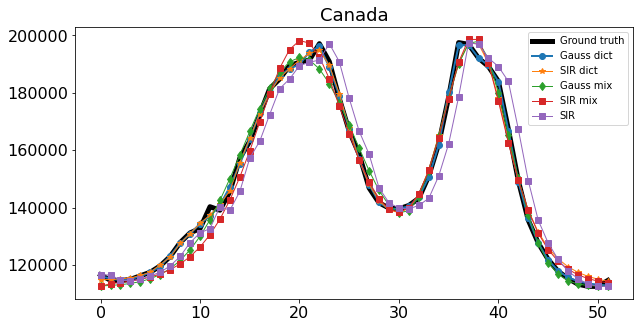

In [7]:
# Create the plot
country_dict = reconstuction_results[country]

plt.figure(figsize=(10,5))
plt.plot(country_dict['Signal_GT'], '-k', linewidth=5)
plt.plot(country_dict['Signal_Gauss_Dict'], marker='o', linewidth=2)
plt.plot(country_dict['Signal_SIR_Dict'], marker='*', linewidth=1)
plt.plot(country_dict['Signal_Gauss_Mix'], marker='d', linewidth=1)
plt.plot(country_dict['Signal_SIR_Mix'], marker='s', linewidth=1)
plt.plot(country_dict['Signal_EKF_SIR'], marker='s', linewidth=1)

plt.legend([
    'Ground truth', 
    'Gauss dict', 
    'SIR dict', 
    'Gauss mix', 
    'SIR mix',
    'SIR'])
plt.title(country, fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()